In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange,tqdm_notebook
from qutip import *

$k_1 = v^2 t^2$

In [5]:
v = 0.1
step = 100
def dynamic_factor0(t,args ):
    return np.cos(args['k1_0'] + 1/2*v*v*t*t)
def dynamic_factor2(t,args ):
    return np.cos(args['k1_0'] + 1/4*v*v*t*t - np.sqrt(3)/4*args['k2'])
def dynamic_factor1(t,args):
    return np.cos(args['k1_0'] + 1/4*v*v*t*t + np.sqrt(3)/4*args['k2'])

# def moving_k2(w,k1,k2,phi,t):
#     delta1 = 1/4*k1 - np.sqrt(3) / 4 * k2
#     delta2 = 1/4*k1 - np.sqrt(3) / 4 * k2
# #geometry factor
#     exc = basis(3,1)
#     g_1 = basis(3,0)
#     g_2 = basis(3,2)
# #basis of a three-level atom
#     u = 2*t*np.exp(1j*phi)
#     u_dag = 2*t*np.exp(-1j*phi)
# #some factors
#     temp = u*np.cos(1/2*k1)*tensor(exc,g_1)
#     H0 = temp+temp.dag()
# #static hamiltonian
#     temp = u.dag*tensor(exc,g_2)
#     H1 = temp+temp.dag()
#     temp = u*tensor(g_1,g_2)
#     H2 = temp+temp.dag()
#     H = [H0,[H1,dynamic_factor1],[H2,dynamic_factor2]]
    

In [12]:
def caculate_chern_k1(w,k2,phi,eigenstate_n):
# w = 0
    k1_0 = 0
    k1_end = np.pi
# k1 = np.pi/4 
# k2 = np.pi/4
# phi = np.pi/3
    delta1_0 = 1/4.0*k1_0 -  np.sqrt(3) / 4.0 * k2
    delta2_0 = 1/4.0*k1_0 + np.sqrt(3) / 4.0 * k2
    #geometry factor
    exc = basis(3,1)
    g_1 = basis(3,0)
    g_2 = basis(3,2)
    #basis of a three-level atom
    u = np.exp(1j*phi)
    u_dag = np.exp(-1j*phi)
    #some factors
    temp = u*g_1*exc.dag()
    H0 = temp+temp.dag()
    temp = u*exc*g_2.dag()
    H1 = temp+temp.dag()
    temp = u_dag*g_1*g_2.dag()
    H2 = temp+temp.dag()
    H_static=+w*exc*exc.dag()+w*g_1*g_1.dag()+w*g_2*g_2.dag()
    F_0= - Qobj([[0,0,np.exp(-1j * phi)*np.sin(delta1_0)*np.sqrt(3)/4],
                [0,0,- np.exp(1j * phi)*np.sin(delta2_0)*np.sqrt(3)/4],
                [np.exp(1j * phi)*np.sin(delta1_0)*np.sqrt(3)/4,-np.exp(-1j * phi)*np.sin(delta2_0)*np.sqrt(3)/4,0]
                ])
    #static hamiltonian
    H = [H_static,[H0,dynamic_factor0],[H1,dynamic_factor1],[H2,dynamic_factor2]]
    #dynamic_hamiltonian
#     psi0 = (H0 * np.cos(delta1_0 + delta2_0) +  H2 * np.cos ( delta2_0) + H1 * np.cos(delta1_0)).eigenstates()[1][eigenstate_n-1]
#     psi0 = psi0+(H0 * np.cos(delta1_0 + delta2_0) + 0.01* H2 * np.cos ( delta2_0) + H1 * np.cos(delta1_0)).eigenstates()[1][eigenstate_n-1 + 1]
#     psi0 = psi0.unit()
    psi0 =  ((H2 * np.cos ( delta2_0) + H1 * np.cos(delta1_0)).eigenstates()[1][eigenstate_n-1]).unit()
    #groundstate
    #the mearsurement quantity
    t_list = np.linspace(0.1,np.sqrt((k1_end - k1_0)/(v*v)),step)
    result = mesolve(H,psi0,t_list,[],args = {'k2':k2 , 'k1_0':k1_0})
    k1_list = []
    result_list = []
    for i in range(step) :
        k1_list.append(k1_0 + v*v*t_list[i]*t_list[i])
        delta1 = 1/4.0*v*t_list[i]*v*t_list[i]+k1_0 - np.sqrt(3) / 4 * k2
        delta2 = 1/4.0*v*t_list[i]*v*t_list[i]+k1_0 + np.sqrt(3) / 4 * k2
        F = - Qobj([[0,0,np.exp(-1j * phi)*np.sin(delta1)*np.sqrt(3)/4],
                [0,0,- np.exp(1j * phi)*np.sin(delta2)*np.sqrt(3)/4],
                [np.exp(1j * phi)*np.sin(delta1)*np.sqrt(3)/4,-np.exp(-1j * phi)*np.sin(delta2)*np.sqrt(3)/4,0]
                ])
        if i > 0:
            result_list.append(expect(F,result.states[i])-expect(F_0,psi0)/(2*v*v*t_list[i]))
        if i == 0:
            result_list.append(0)
    return [result_list,k1_list]

In [13]:
k2 = np.linspace(0,np.pi,step)
Z = []
for i in tnrange(step,desc='process:'):
    Z.append(caculate_chern_k1(0,k2[i],np.pi/6,2)[0])
k1 = caculate_chern_k1(0,k2[step-1],np.pi/6,1)[1]

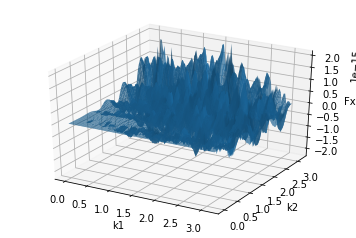

In [14]:
k1,k2 = np.ogrid[0:np.pi:step * 1j,0:np.pi:step * 1j]
ax=plt.subplot(111,projection='3d')
ax.plot_surface(k1,k2,Z,rstride=2,cstride=1,alpha=0.8)
ax.set_xlabel('k1')
ax.set_ylabel('k2')
ax.set_zlabel('Fxy')

In [15]:
integral = 0
r = 0
epsi = np.pi*np.pi/((step-r)*(step-r))
for i in range(step-r):
    for j in range(step-r):
        integral+=Z[i+r][j+r]*epsi
print integral * 4

-1.36083641098e-15


In [6]:
phi = np.pi/4
w=0
#geometry factor
exc = basis(3,1)
g_1 = basis(3,0)
g_2 = basis(3,2)
#basis of a three-level atom
u = np.exp(1j*phi)
u_dag = np.exp(-1j*phi)
#some factors
temp = u*g_1*exc.dag()
H0 = temp+temp.dag()
temp = u*exc*g_2.dag()
H1 = temp+temp.dag()
temp = u_dag*g_1*g_2.dag()
H2 = temp+temp.dag()
H_static=+w*exc*exc.dag()+w*g_1*g_1.dag()+w*g_2*g_2.dag()

In [16]:
k1 = caculate_chern_k1(0,k2[step-1],np.pi/6,1)[1]

In [16]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
Alexander Pitchford, Chris Granade, Paul D. Nation & Robert J. Johansson

QuTiP Version:      4.0.2
Numpy Version:      1.12.0
Scipy Version:      0.18.1
Cython Version:     0.25.2
Matplotlib Version: 2.0.0
Python Version:     2.7.13
Number of CPUs:     4
BLAS Info:          INTEL MKL
INTEL MKL Ext:      True
Platform Info:      Windows (AMD64)
Installation path:  C:\Users\caidish\Anaconda2\lib\site-packages\qutip

